The purpose of this code is to compute the Absolute Magnitude of the candidates (Both KDE and RF) and plot them as a function of redshift. The conversion is as follows:

$M = m - 5log_{10}(\frac{d}{10\mathrm{pc}})$ or, in Mpc

$M = m - (5log_{10}(\frac{d}{1\mathrm{Mpc}})-5log_{10}(10^{5})) == m - 5log_{10}(\frac{d}{1\mathrm{Mpc}})-25$

where d is the Luminosity distance in parsecs. The distance is estimated using the photoz's and a $\Lambda$CDM Cosmology with parameters:

$H_0 = 70 Mpc^{-1}, 
\Omega_{\Lambda} = 0.725, 
\Omega_{M} = 0.275$

Using the Friedmann Equation:

$ $

We can compute distance and, using the i_mag I can determine the absolute magnitude at z=0. I Finally need to convert to $M_i[z=2]$ by using the $\alpha_\nu$ values from Richards 2006/Ross2013

In [1]:
%matplotlib inline
import os
import sys
sys.path.insert(0, '/home/john/densityplot/densityplot')
from densityplot.hex_scatter import hex_contour as hex_contour
import numpy as np
from astropy.io import fits as pf
import camb
from camb import model
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [56]:
#open the candidate data
#path = '/Users/johntimlin/Clustering/Combine_SpIES_Shela/Data_sets/Match_SpSh_Cand_wzcorrected_nooutlier_allinfo.fits'
#path = '/Users/johntimlin/Catalogs/QSO_candidates/201606/All_hzcandidate_correctphotoz_fromgaussian_allinfo.fits'
#path = '../Data_Sets/QSO_Candidates_allcuts_with_errors_visualinsp.fits'
path = '../Data_Sets/Only_point_sources.fits'



data = pf.open(path)[1].data

print data['imag']
print data.zphotNW

rz = (data.zphotNW>=2.9) & (data.zphotNW<=5.4) & (data.Good_obj == 0) & (data.dec>=-1.2) & (data.dec<=1.2)& (data['imag']>=20.2)
rshift = data.zphotNW[rz]

print rshift.dtype
r = rshift.astype('float64') #camb's luminosity distance calculator only accepts float 64 data types
print r.dtype

[ 20.17960974  20.25395364  21.08268422 ...,  21.32841916  21.49024784
  21.59213161]
[ 2.90104425  2.90329577  2.90388668 ...,  5.03999996  5.04710007
  5.11000013]
>f8
float64


In [57]:
print len(r)


1288


In [58]:
#mag_list.append(-1.0*pogson*(math.asinh(5.0*fluxs[flux_name][i]/bsoft[flux_name]) + ln10_min10 + math.log(bsoft[flux_name])) - extinctions[flux_name][i] )

pog_m = 22.5-2.5*np.log10(data.iflux[rz])
# b=1.8 × 10-10 for i-band
ash_m = -2.5/np.log(10) * (np.arcsinh((data.iflux[rz]/1e9)/(2*1.8e-10))+np.log(1.8e-10)) - 1.698/5.155 * data.extinctu[rz]

In [59]:
print pog_m
print ash_m
print 1.698/4.239 * data.extinctu[rz]
print -2.5*np.log10(1/3631.0e5)

[ 20.25395364  21.08268422  21.48169273 ...,  21.32841916  21.49024784
  21.59213161]
[ 20.17204888  21.03884775  21.40176209 ...,  21.27709683  21.32829998
  21.52489267]
[ 0.09892102  0.05017692  0.09069579 ...,  0.05749727  0.19033342
  0.07380672]
21.4000656223


In [60]:
#Open the Shen2007 data
shendat = '/Users/johntimlin/Clustering/Shen_test/Data/Shen2007_Clustering_sample.fits'
sdat = pf.open(shendat)[1].data
#Cut to their objects and get array of redshifts
sdx = (sdat.Sfl == 1) #& (sdat.z>=3.5) & (sdat.z<=5.4)
srz = sdat.z[sdx]
sr = srz.astype('float64')
#print simag

In [61]:
#First define Planck 2015 cosmological parameters
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons
#Set up parameters in CAMB
pars = camb.CAMBparams()
#Conversion to density param: Omega_Matter = (oc+ob)/(H0/100.)**2
#Hard code the cosmolgy params
pars.H0=H #hubble param (No h!!)
pars.omegab=ob #Baryon density parameter
pars.omegac=oc #CDM density parameter
pars.omegav=0.725 #Vacuum density parameter
pars.set_dark_energy()

#Set up parameters in CAMB
pars = camb.CAMBparams()
#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 
pars.set_dark_energy()

bkg = camb.get_background(pars) #Background parameters 


Ldist = bkg.luminosity_distance(r) #Luminosity distance for SpIES cand
ShLdist = bkg.luminosity_distance(sr) #Luminosity distance for Shen qso


#Make the i_mag line targeted for shen 2007
sampz = np.linspace(0.5,5.4,10000)
line = bkg.luminosity_distance(sampz)
const_mag = np.ones(len(line))*20.2
const_magsp = np.ones(len(line))*22.5

In [62]:
#Compute the absolute magnitude at z=0
#M = (22.5-2.5*np.log10(data.iflux[rz])) - 5.0*np.log10(Ldist) - 25.0
M = ash_m - 5.0*np.log10(Ldist) - 25.0
M202 = const_mag - 5.0*np.log10(line) - 25.0
M23 = const_magsp - 5.0*np.log10(line) - 25.0
shenM = sdat['imag'][sdx] - 5.0*np.log10(ShLdist) - 25.0


In [63]:
#Compute the corrections to apply to M[z=0] to get M[z=2]
def Kcorr(z,alpha = -0.5):
    #Ross13
    K13 = -2.5*np.log10(1+z) - 2.5*alpha*np.log10(1+z)+2.5*alpha*np.log10(1.0+2.0)
    return K13
#import the K-corrections from Richards 2006
K06 = pf.open('./K_correct_Richards06.fits')[1].data
K13 = pf.open('./K_correct_Ross13.fits')[1].data

#Pull out the redshift information from the data for SpIES and Shen
rshifts = data.zphotNW[rz]
srshift = sdat.z[sdx]

#Round the redshifts to 2 decimal places so that I can match to the correction values in Richards 2006
roundz = np.round(rshifts,decimals = 2)
roundt = np.round(sampz,decimals = 2)
roundsz = np.round(srshift,decimals = 2)

#Find the correction value that corresponds to the redshift in the file
Kcor=[]
Ktest = []
Ktestsp = []
Kshen = []
for i in roundz:
    kc = K06.KCorr[np.where(K06.z == i)]
    Kcor.append(kc[0])
    
for j in roundt:
    kt = K06.KCorr[np.where(K06.z == j)] 
    Ktest.append(kt[0])
    Ktestsp.append(kt[0])
for m in roundsz:
    kt = K06.KCorr[np.where(K06.z == j)] 
    Kshen.append(kt[0])


KC = np.asarray(Kcor)
KT = np.asarray(Ktest)
KS = np.asarray(Kshen)

#Correct the Absolute values using the K-corrections found above
dcorrect = M-KC
lcorrect = M202-Ktest
spcorrect= M23 - Ktestsp
scorrect = shenM - Kshen



In [64]:
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 16, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

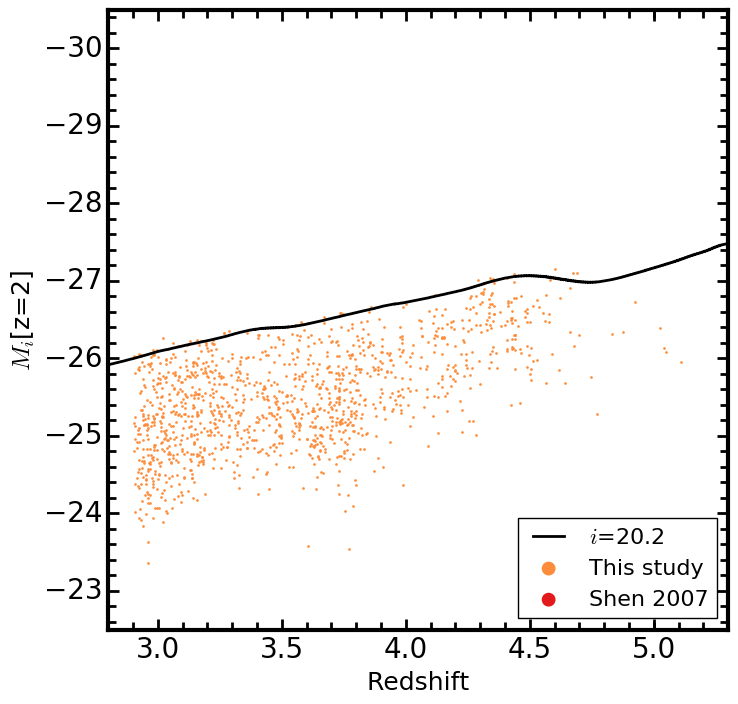

In [65]:
plt.figure(1,figsize = (8,8))
plt.scatter(rshift,dcorrect,color = '#fd8d3c',edgecolor = None,s=1,alpha = 0.9)#,label = 'Timlin 2016 QSO sample' )
plt.scatter(1,1,s=80,color = '#fd8d3c',label = 'This study')
#plt.scatter(srz,scorrect,color='#e31a1c',edgecolor = None,s=1,alpha = 0.9)#,label = 'Shen 2007 QSO sample')
plt.scatter(1,1,s=80,color = '#e31a1c',label = 'Shen 2007')

plt.plot(sampz,lcorrect,color = 'k',linewidth = 2,label = r'$i$=20.2')

#plt.plot(sampz,spcorrect,color = 'g',linewidth = 2,label = r'$i$=22.5')

#plt.plot(sampz,spcorrect,color = 'k',linestyle = '--', dashes=(10,5,10,5),linewidth = 2,label = r'$i$=23.3')
plt.xlim(2.8,5.3)
plt.ylim(-30.5,-22.5)
plt.xlabel('Redshift',fontsize = 18)
plt.ylabel(r'$M_i$[z=2]',fontsize = 18)
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.legend(loc=4,scatterpoints = 1)

#plt.savefig('Absolute_Mag_SpIES_Shen.pdf')

[ 20.0006963   20.14679917  20.29290205  20.43900492  20.5851078
  20.73121067  20.87731355  21.02341642  21.16951929  21.31562217
  21.46172504  21.60782792  21.75393079  21.90003367  22.04613654
  22.19223941  22.33834229  22.48444516  22.63054804  22.77665091
  22.92275379  23.06885666  23.21495953]


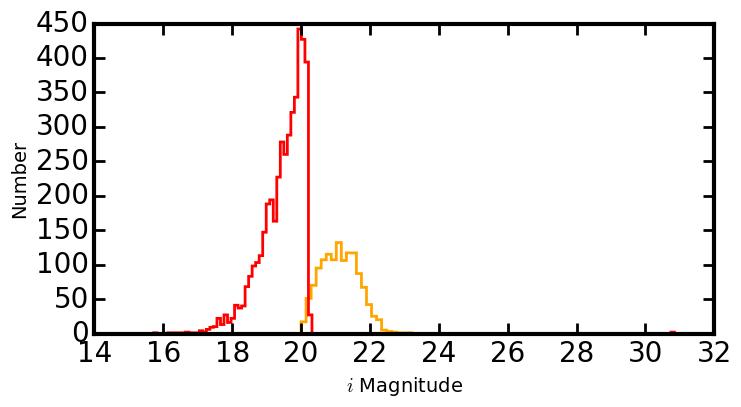

In [70]:
imag = -2.5/np.log(10) * (np.arcsinh((data.iflux[rz]/1e9)/(2*1.8e-10))+np.log(1.8e-10)) - 1.698/4.239 * data.extinctu[rz]

num,bins = np.histogram(imag,bins='fd')

print bins

fig = plt.figure(5,figsize = (8,4))
plt.hist(imag,bins, histtype = 'step',normed = False,color = '#FFA500',linewidth = 2)
plt.hist(sdat['imag'][sdx],bins='fd', histtype = 'step',normed = False,color = 'r',linewidth = 2)
plt.xlabel(r'$i$ Magnitude',fontsize = 14)
plt.ylabel('Number',fontsize = 14)
#plt.savefig('imag_hist.pdf',bbox_inches='tight')

plt.show()


# Plot for the paper

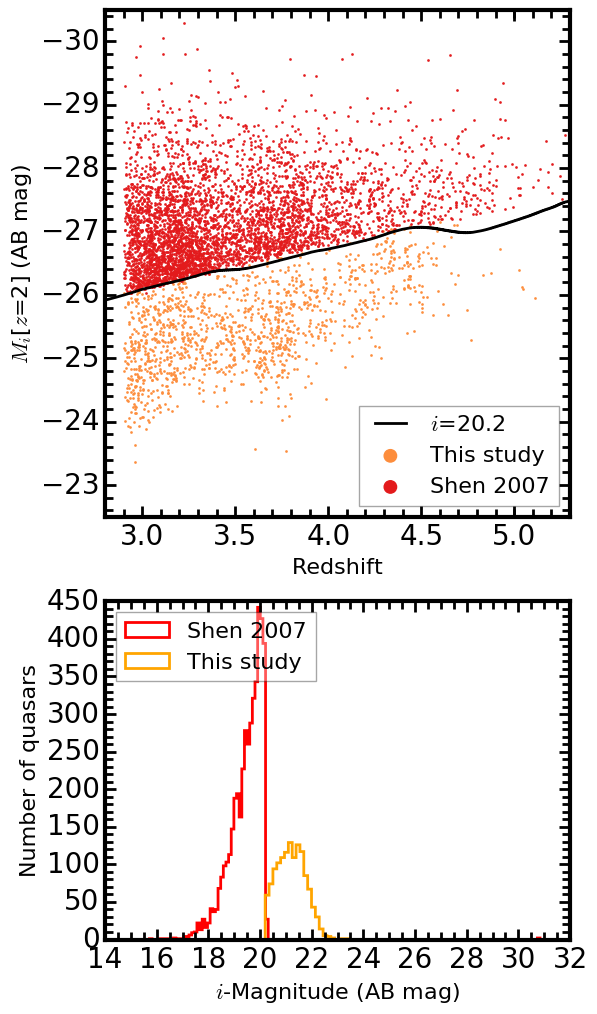

In [71]:
imag = 22.5-2.5*np.log10(data.iflux[rz])

num,bins = np.histogram(imag,bins='fd')

fig = plt.figure(5,figsize = (6,12))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.6,0.4])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],)

plt.axes(ax0)

plt.scatter(rshift,dcorrect,color = '#fd8d3c',edgecolor = None,s=1,alpha = 0.9)#,label = 'Timlin 2016 QSO sample' )
plt.scatter(1,1,s=80,color = '#fd8d3c',label = 'This study')
plt.scatter(srz,scorrect,color='#e31a1c',edgecolor = None,s=1,alpha = 0.9)#,label = 'Shen 2007 QSO sample')
plt.scatter(1,1,s=80,color = '#e31a1c',label = 'Shen 2007')
plt.plot(sampz,lcorrect,color = 'k',linewidth = 2,label = r'$i$=20.2')
#plt.plot(sampz,spcorrect,color = 'k',linestyle = '--', dashes=(10,5,10,5),linewidth = 2,label = r'$i$=23.3')
plt.xlim(2.8,5.3)
plt.ylim(-30.5,-22.5)
plt.xlabel('Redshift',fontsize = 16)
plt.ylabel(r'$M_i$[$z$=2] (AB mag)',fontsize = 16)
plt.gca().invert_yaxis()
plt.minorticks_on()
leg =plt.legend(loc=4,scatterpoints = 1)
leg.get_frame().set_alpha(0.35)

plt.axes(ax1)
plt.hist(sdat['imag'][sdx],bins='fd', histtype = 'step',normed = False,color = 'r',linewidth = 2,label= 'Shen 2007')
plt.hist(imag,bins, histtype = 'step',normed = False,color = '#FFA500',linewidth = 2,label = 'This study')

plt.xlabel(r'$i$-Magnitude (AB mag)',fontsize = 16)
plt.ylabel('Number of quasars',fontsize = 16)
plt.minorticks_on()
leg =plt.legend(loc=2)
leg.get_frame().set_alpha(0.35)

#plt.savefig('Absolute_Mag_SpIES_Shen.pdf',bbox_inches='tight',pad_inches=0.5)


# Find and save the brightest candidates

In [17]:
good = dcorrect[dcorrect <=-25.0]
print len(good)

4532


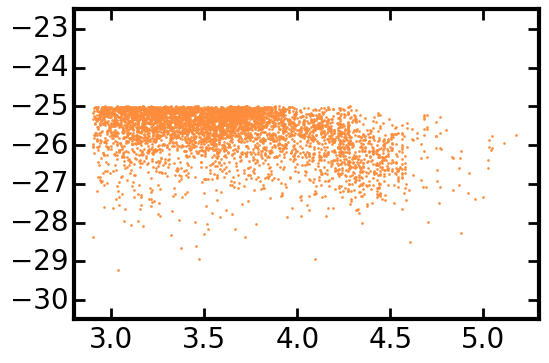

In [31]:
plt.scatter(rshift[dcorrect<=-25],good,color = '#fd8d3c',edgecolor = None,s=1,alpha = 0.9)#,label = 'Timlin 2016 QSO sample' )
plt.scatter(1,1,s=80,color = '#fd8d3c',label = 'This study')
plt.xlim(2.8,5.3)
plt.ylim(-30.5,-22.5)
plt.show()


In [33]:
print len(data.ra[rz]), len(dcorrect)
print len(data.ra[rz][dcorrect<=-25.0])

8838 8838
4532


In [32]:
tbhdu=pf.BinTableHDU.from_columns([pf.Column(name='RA',format='D',array=data.ra[rz][dcorrect<=-25.0]),
pf.Column(name='DEC',format='D',array=data.dec[rz][dcorrect<=-25.0])])


prihdr=pf.Header()
prihdr['COMMENT']="Brightest SpIES quasars"
prihdu=pf.PrimaryHDU(header=prihdr)

hdulist = pf.HDUList([prihdu,tbhdu])

#hdulist=pf.HDUList(data[dx])
hdulist.writeto('../Data_Sets/Brightest_candidates.fits')
